# MODIS Pipeline Walkthrough

In this demo, we will do a full walkthrough of a minimal MODIS pipeline to get some data for training

In [3]:
import autoroot
from rs_tools._src.utils.io import get_list_filenames
import rioxarray
import xarray as xr
import numpy as np
import earthaccess
from pathlib import Path
from rs_tools._src.data.modis.bands import MODIS_VARIABLES
from rs_tools._src.data.modis import MODISFileName, MODIS_ID_TO_NAME, MODIS_NAME_TO_ID, get_modis_paired_files

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from dataclasses import dataclass
from tqdm.auto import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
save_dir_raw = "/home/juanjohn/data/rs/modis/raw/modis"
save_dir_analysis = "/home/juanjohn/data/rs/modis/analysis/"
save_dir_mlready = "/home/juanjohn/data/rs/modis/mlready/"

## 1 - Download Data

For this case, we are going to download MODIS data.

* AQUA - "MYDO21KM"
* TERRA - "MODO21KM"
* Geolocation - "MYDO3"

**Resources**:
* NASA LAADS - [Webpage](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/science-domain/modis-L0L1/)

In [4]:
earthaccess.login()

#### Demo: Terra

In [5]:
results = earthaccess.search_data(
    short_name=MODIS_NAME_TO_ID["terra"], # 'MYD03' # "MYD021KM"
    cloud_hosted=True,
    bounding_box=(-130, -15, -90, 5),
    temporal=("2018-10-01 08:00", "2018-10-01 20:00"),
    count=-1
)
results[0]

Granules found: 5


Collection: {'ShortName': 'MOD021KM', 'Version': '6.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -93.519163, 'Latitude': -16.615312}, {'Longitude': -71.610842, 'Latitude': -19.897712}, {'Longitude': -68.271652, 'Latitude': -1.855952}, {'Longitude': -89.116255, 'Latitude': 1.202545}, {'Longitude': -93.519163, 'Latitude': -16.615312}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2018-10-01T15:45:00.000Z', 'EndingDateTime': '2018-10-01T15:50:00.000Z'}}
Size(MB): 142.835767745972
Data: ['https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2018/274/MOD021KM.A2018274.1545.061.2018275090337.hdf']

### Download Loop

In [6]:
# pbar = tqdm(list(modis_satellite_names.values()))

# for isatellite in pbar:

#     # search for data in database
#     results = earthaccess.search_data(
#         short_name=isatellite,
#         cloud_hosted=True,
#         bounding_box=(-130, -15, -90, 5),
#         temporal=("2018-10-01 08:00", "2018-10-01 20:00"),
#         count=-1
#     )

#     # download if something found
#     if len(results) != 0:
#         earthaccess.download(results, save_dir_raw)

## 2 - Loading Data

1. Get All Files
2. Create MODISFileName Identifiers
3. Filter Based on criteria

In [5]:
modis_files = get_list_filenames(save_dir_raw, ".hdf")
modis_files[0], len(modis_files)

('/home/juanjohn/data/rs/modis/raw/modis/MOD021KM.A2018274.1545.061.2018275090337.hdf',
 22)

In [6]:
from typing import List


# get all modis files
modis_filenames: List[MODISFileName] = list(map(lambda x: MODISFileName.from_filename(x), modis_files))

# get paired files for satellites
paired_files_terra = get_modis_paired_files(modis_filenames, "terra")

Now, we will filter for the unique datetimes

### Open File

In [7]:
import satpy
from satpy import Scene
from rs_tools import get_modis_channel_numbers
import rioxarray
import xarray as xr

In [8]:
demo = next(iter(paired_files_terra))

In [9]:
list(paired_files_terra.keys())

['201810011545',
 '201810011720',
 '201810011725',
 '201810011900',
 '201810011905',
 '201810021625',
 '201810021630',
 '201810021805',
 '201810021810',
 '201810021940',
 '201810021945']

## Bands

In [46]:
scn = Scene(
    reader="modis_l1b", 
    filenames=[
        str(paired_files_terra[demo]["data"].full_path),
    ], 
)
resolution = 1_000 # km scale
scn.load(get_modis_channel_numbers(), resolution = resolution, calibration="radiance")



In [60]:
# change to xarray data
ds_modis = scn.to_xarray_dataset()
crs_WGS84 = ccrs.PlateCarree(central_longitude=0) 
ds_modis.rio.write_crs(crs_WGS84, inplace=True)
ds_modis.rio.set_spatial_dims(
    x_dim="x",
    y_dim="y",
    inplace=True)
ds_modis.rio.write_coordinate_system(inplace=True)

<xarray.Dataset> Size: 440MB
Dimensions:      (y: 2030, x: 1354)
Coordinates:
    crs          object 8B +proj=longlat +ellps=WGS84 +type=crs
    latitude     (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude    (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Data variables: (12/38)
    6            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    8            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    10           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    15           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    17           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    20           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    ...           ...
    14lo         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    12           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    34           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    13lo         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    27           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    4            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Attributes: (12/15)
    reader:               modis_l1b
    start_time:           2018-10-01 15:45:00
    coordinates:          ('longitude', 'latitude')
    platform_name:        EOS-Terra
    rows_per_scan:        10
    modifiers:            ()
    ...                   ...
    resolution:           1000
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'getit...
    sensor:               modis
    ancillary_variables:  []
    standard_name:        toa_outgoing_radiance_per_unit_wavelength
    file_type:            hdf_eos_data_1000m

In [63]:
SPHERE_RADIUS = 6371007.181 # Radius of ideal sphere, meters

def modis_from_wgs84(coords):
    '''
    Given longitude-latitude coordinates, return the coordinates on the
    sinusoidal projection plane.

    Parameters
    ----------
    coords : tuple or list
        (Longitude, Latitude) coordinate pair

    Returns
    -------
    tuple
        (X, Y) coordinate pair in MODIS sinusoidal projection
    '''
    x, y = map(np.deg2rad, coords)
    return (SPHERE_RADIUS * x * np.cos(y), SPHERE_RADIUS * y)

In [70]:
# coords = list(zip(ds_modis.latitude.values.ravel(),ds_modis.longitude.values.ravel()))

In [71]:
# out = list(map(modis_from_wgs84, coords))

In [64]:
# out = ds_modis.rio.reproject(crs.Sinusoidal.MODIS)

In [44]:
ds_modis

<xarray.Dataset> Size: 440MB
Dimensions:    (y: 2030, x: 1354)
Coordinates:
    crs        object 8B +proj=longlat +ellps=WGS84 +type=crs
    latitude   (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude  (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables: (12/38)
    6          (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    8          (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    10         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    15         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    17         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    20         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    ...         ...
    14lo       (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    12         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    34         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    13lo       (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    27         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    4          (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Attributes: (12/15)
    reader:               modis_l1b
    start_time:           2018-10-01 15:45:00
    coordinates:          ('longitude', 'latitude')
    platform_name:        EOS-Terra
    rows_per_scan:        10
    modifiers:            ()
    ...                   ...
    resolution:           1000
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'getit...
    sensor:               modis
    ancillary_variables:  []
    standard_name:        toa_outgoing_radiance_per_unit_wavelength
    file_type:            hdf_eos_data_1000m

In [12]:
from georeader import get_utm_epsg

In [17]:
ds_modis.latitude.values.ravel().shape

(2748620,)

In [30]:
coords = list(zip(ds_modis.latitude.values.ravel(),ds_modis.longitude.values.ravel()))
crss = list(set(map(lambda x: get_utm_epsg((x[0],x[1])), coords)))

In [47]:
from cartopy import crs

<Projected CRS: +proj=sinu +a=6371007.181 +b=6371007.181 +lon_0=0. ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Sinusoidal
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [50]:
crs.Sinusoidal.MODIS(
    globe=crs.Globe(
        ellipse=None, 
        semimajor_axis=6371007.181,
        semiminor_axis=6371007.181)
)

TypeError: 'Sinusoidal' object is not callable

In [11]:
ds_modis

<xarray.Dataset> Size: 616MB
Dimensions:    (y: 2030, x: 1354)
Coordinates:
    crs        object 8B +proj=longlat +ellps=WGS84 +type=crs
    latitude   (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude  (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables: (12/38)
    5          (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    31         (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    35         (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    19         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    25         (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    2          (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    ...         ...
    10         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    33         (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    20         (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    9          (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    12         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    3          (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Attributes:
    reader:               modis_l1b
    start_time:           2018-10-01 15:45:00
    coordinates:          ('longitude', 'latitude')
    platform_name:        EOS-Terra
    rows_per_scan:        10
    modifiers:            ()
    end_time:             2018-10-01 15:50:00
    resolution:           1000
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'getit...
    sensor:               modis
    ancillary_variables:  []
    file_type:            hdf_eos_data_1000m

In [14]:
# create new channel dimension
ds_modis = xr.concat(list(map(lambda x: ds_modis[x], get_modis_channel_numbers())), dim="channel")
# rename channel dimensions
ds_modis = ds_modis.assign_coords(channel=list(map(lambda x: x, get_modis_channel_numbers())))

In [15]:
ds_modis

<xarray.DataArray '1' (channel: 38, y: 2030, x: 1354)> Size: 836MB
dask.array<concatenate, shape=(38, 2030, 1354), dtype=float64, chunksize=(1, 1540, 1354), chunktype=numpy.ndarray>
Coordinates:
    crs        object 8B +proj=longlat +ellps=WGS84 +type=crs
    latitude   (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude  (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
  * channel    (channel) <U4 608B '1' '2' '3' '4' ... '35' '36' '13hi' '14hi'
Dimensions without coordinates: y, x
Attributes: (12/18)
    name:                 1
    resolution:           1000
    calibration:          reflectance
    coordinates:          ('longitude', 'latitude')
    wavelength:           0.645 µm (0.62-0.67 µm)
    file_type:            hdf_eos_data_1000m
    ...                   ...
    start_time:           2018-10-01 15:45:00
    end_time:             2018-10-01 15:50:00
    reader:               modis_l1b
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'getit...
    _satpy_id:            DataID(name='1', wavelength=WavelengthRange(min=0.6...
    ancillary_variables:  []

#### Load Mask

In [16]:
scn = Scene(
    reader="modis_l2", 
    filenames=[
        str(paired_files_terra[demo]["cloud"].full_path),
    ], 
    reader_kwargs={"calibration": "radiance"}
)
resolution = 1_000 # km scale
scn.load(["cloud_mask"], resolution = resolution)

### Saving Data Structure

In [17]:
from datetime import datetime

In [18]:
ds_modis = ds_modis.assign_coords({"cloud_mask": (("y","x"),scn["cloud_mask"].values)})
ds_modis = ds_modis.expand_dims(time=[datetime.strptime(demo, "%Y%m%d%H%M"),])
ds_modis = ds_modis.drop_vars("crs")


useful_keys = ["calibration", "wavelength", "standard_name"]
ds_modis.attrs = {k: v for k, v in ds_modis.attrs.items() if k in useful_keys}

ds_modis.name = "reflectance"
ds_modis

<xarray.DataArray 'calibration' (time: 1, channel: 38, y: 2030, x: 1354)> Size: 836MB
dask.array<broadcast_to, shape=(1, 38, 2030, 1354), dtype=float64, chunksize=(1, 1, 1540, 1354), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 8B 2018-10-01T15:45:00
    latitude    (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude   (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
  * channel     (channel) <U4 608B '1' '2' '3' '4' ... '35' '36' '13hi' '14hi'
    cloud_mask  (y, x) uint8 3MB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 1 2 1 1 0 0 0 0 0
Dimensions without coordinates: y, x
Attributes:
    calibration:    reflectance
    wavelength:     0.645 µm (0.62-0.67 µm)
    standard_name:  toa_bidirectional_reflectance

## Stage 3

* Normalization
* Patching

#### Running Mean

In [19]:
def mean_preprocess(ds):
    # calculate the mean
    ds = ds.reflectance.mean(["x", "y"])
    return ds

In [20]:
ds_mean = xr.open_mfdataset(str(Path(save_dir_analysis).joinpath("*.nc")), preprocess=mean_preprocess, combine="by_coords",  engine="netcdf4")

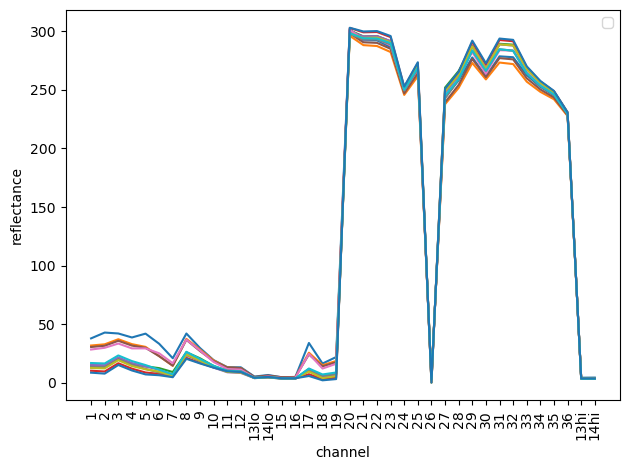

In [21]:
fig, ax = plt.subplots()
ds_mean.reflectance.plot.line(x="channel", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

In [22]:
ds_mean = ds_mean.mean(["time"])

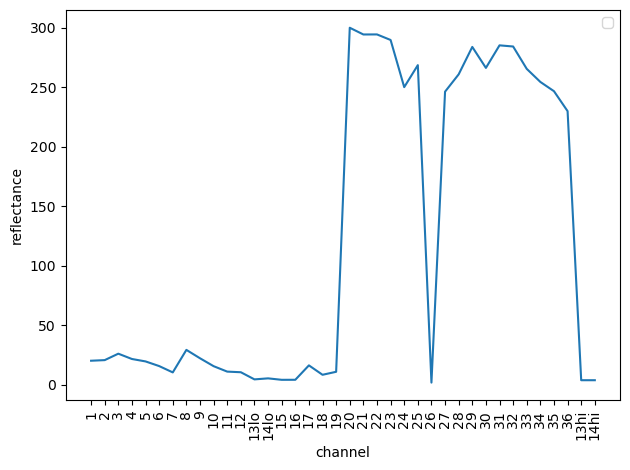

In [23]:
fig, ax = plt.subplots()
ds_mean.reflectance.plot.line(x="channel", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

In [24]:
def std_preprocess(ds):
    # calculate the mean
    ds = ((ds.reflectance - ds_mean)**2).std(["x","y"])
    return ds

In [25]:
ds_std = xr.open_mfdataset(str(Path(save_dir_analysis).joinpath("*.nc")), preprocess=std_preprocess, combine="by_coords",  engine="netcdf4")

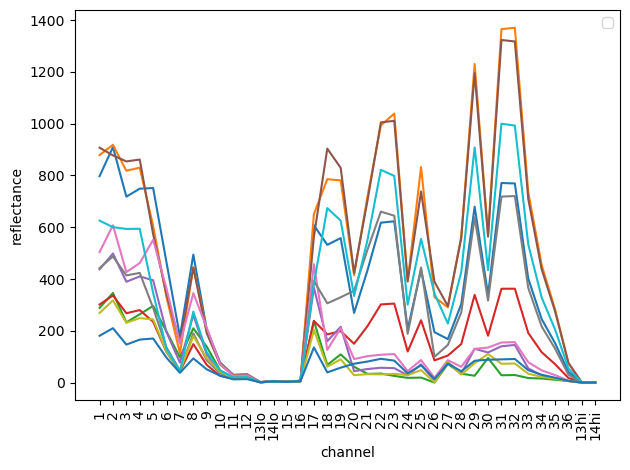

In [26]:
fig, ax = plt.subplots()
ds_std.reflectance.plot.line(x="channel", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

In [27]:
ds_std = ds_std.mean(["time"])

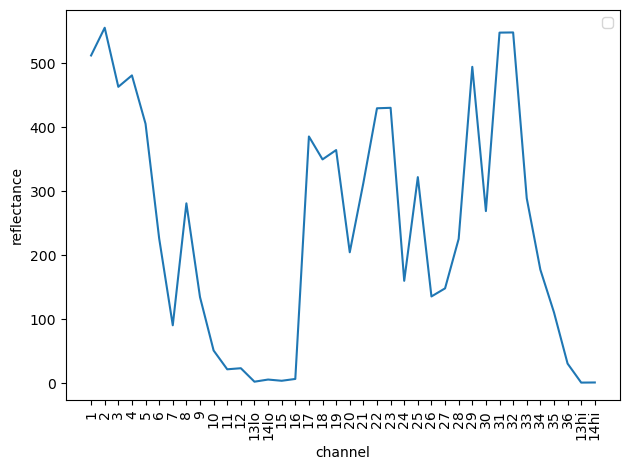

In [28]:
fig, ax = plt.subplots()
ds_std.reflectance.plot.line(x="channel", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

### Normalization

In [23]:
ds["mean"] = ds.mean(["x", "y", "time"]).reflectance
ds["std"] = ds.mean(["x", "y", "time"]).reflectance

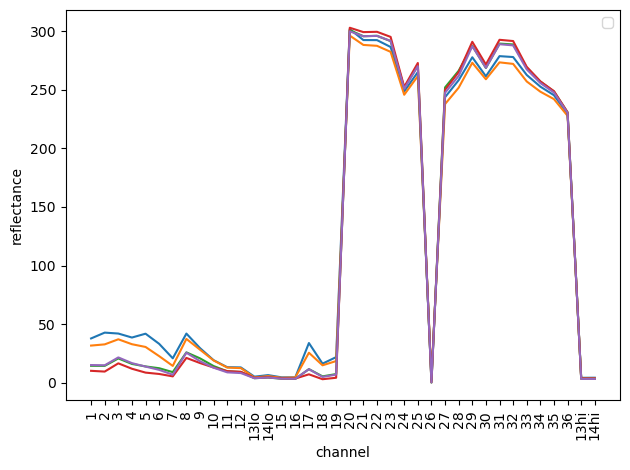

In [24]:
fig, ax = plt.subplots()
ds.mean(["x", "y"]).reflectance.plot.line(x="channel", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

### Patching

In [59]:
from xrpatcher._src.base import XRDAPatcher

In [60]:
patches = dict(x=256, y=256)
strides = dict(x=64, y=64)
patcher = XRDAPatcher(da=ds.reflectance, patches=patches, strides=strides)

In [61]:
len(patcher)

504

In [62]:
ipatch = patcher[0]
ipatch

<xarray.DataArray 'reflectance' (time: 5, channel: 38, y: 256, x: 256)> Size: 100MB
dask.array<getitem, shape=(5, 38, 256, 256), dtype=float64, chunksize=(1, 38, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 40B 2018-10-01T15:45:00 ... 2018-10-01T...
    latitude    (time, y, x) float32 1MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
    longitude   (time, y, x) float32 1MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
  * channel     (channel) <U4 608B '1' '2' '3' '4' ... '35' '36' '13hi' '14hi'
    cloud_mask  (time, y, x) uint8 328kB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes:
    calibration:    reflectance
    wavelength:     ['0.62', '0.645', '0.67', 'µm']
    standard_name:  toa_bidirectional_reflectance

In [63]:

for i, ipatch in enumerate(patcher):
    # save as numpy files
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_reflectance_patch_{i}.npz"), ipatch.values)
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_latitude_patch_{i}.npz"), ipatch.latitude.values)
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_longitude_patch_{i}.npz"), ipatch.longitude.values)
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_cloudmask_patch_{i}.npz"), ipatch.cloud_mask.values)
    break

In [46]:
mldata_dir = Path("/home/juanjohn/data/rs/modis/mlready")

In [47]:
# !ls $mldata_dir

## Datasets, DataLoaders

In [40]:
from torch.utils.data import Dataset, DataLoader
from typing import Optional, Callable

In [88]:
class ImageDataReader(Dataset):
    def __init__(self, data_dir: str, ext: str=".npy", transforms: Optional[Callable]=None):
        self.data_dir = data_dir
        data_filenames = get_list_filenames(data_dir, ext)
        # filter files
        self.data = list(filter(lambda x: "reflectance" in x, data_filenames))
        self.lats = list(filter(lambda x: "latitude" in x, data_filenames))
        self.lons = list(filter(lambda x: "longitude" in x, data_filenames))
        self.masks = list(filter(lambda x: "cloudmask" in x, data_filenames))
        assert len(self.data) == len(self.lats) == len(self.lons) == len(self.masks)
        self.transforms = transforms

    def __getitem__(self, ind) -> np.ndarray:
        sample = {}
        sample["data"] = np.load(self.data[ind], mmap_mode="r+")
        sample["lats"] = np.load(self.lats[ind], mmap_mode="r+")
        sample["lons"] = np.load(self.lons[ind], mmap_mode="r+")
        sample["mask"] = np.load(self.masks[ind], mmap_mode="r+")
        if self.transforms is not None:
            sample = self.transforms(sample)
        return sample

    def __len__(self):
        return len(self.data)

In [89]:
ds = ImageDataReader("/home/juanjohn/data/rs/modis/mlready")

In [87]:
isample = ds[0]

#### DataLoader

In [83]:
dl = DataLoader(ds, batch_size=64, shuffle=False)

In [84]:
for isample in dl:
    break

In [85]:
isample["data"].shape

torch.Size([64, 1, 38, 256, 256])